In [2]:
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import scanpy.external as sce

from ALLCools.clustering import significant_pc_test
from ALLCools.plot import *
from harmonypy import run_harmony
import pandas as pd
import os
import argparse


In [3]:
input_file= "atacsc-3region-pseudo-clusteringlamb0.5_nclust10.harmony.h5ad"

In [4]:
adata_concat = anndata.read_h5ad(f'output/{input_file}')


In [ ]:
# adata_sc = sc.pp.subsample(adata_concat[adata_concat.obs.batch.str.contains('atac')], n_obs=6000, copy=True)
# adata_atac = sc.pp.subsample(adata_concat[adata_concat.obs.batch.str.contains('sc')], n_obs=3000, copy=True)

In [56]:
adata_sc = adata_concat[adata_concat.obs.batch.str.contains('atac')]
adata_atac = adata_concat[adata_concat.obs.batch.str.contains('sc')]

In [57]:
adata_atac

View of AnnData object with n_obs × n_vars = 6294 × 2980
    obs: 'n_cells', 'leiden', 'n_counts', 'leiden_snap', 'celltype.L1', 'batch'
    var: 'highly_variable', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'chr-0', 'gene_name-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'feature_types-1', 'genome-1', 'mt-1', 'gane_name-1'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [58]:
from scipy.spatial import cKDTree


In [59]:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    d1,k_index_1 = cKDTree(data1).query(x=data2, k=k1, workers=n_jobs)
    d2,k_index_2 = cKDTree(data2).query(x=data1, k=k2, workers=n_jobs)
    mutual_1 = []
    mutual_2 = []
    dist1 = []
    dist2 = []
    for index_2 in range(data2.shape[0]):
        for index_1 in k_index_1[index_2]:
            for i in range(len(k_index_2[index_1])):
                if k_index_2[index_1][i] == index_2:
                    mutual_1.append(index_1)
                    mutual_2.append(index_2)
                    dist1.append(d2[index_1][i])
            # if index_2 in k_index_2[index_1]:
            #     mutual_1.append(index_1)
            #     mutual_2.append(index_2)
                # dist1.append(d1[index_2])
                # dist2.append(d2[index_1])
    return mutual_1, mutual_2, dist1, d1,d2

rs = find_mutual_nn(adata_sc.obsm['X_pca_harmony'], adata_atac.obsm['X_pca_harmony'], 20, 20, 10)

In [75]:
df = pd.DataFrame({'sc': rs[0], 'atac': rs[1], 'dist': rs[2],'atac_pseudo':adata_atac[rs[1]].obs.index, 'sc_pseudo':adata_sc[rs[0]].obs.index})

In [67]:
len(set(rs[1]))

4494

In [77]:
df.to_csv('output/pseudo_sc_atac_nn.csv', index=False)

In [ ]:
adata_atac[rs[1]]

,n_cells,leiden,n_counts,leiden_snap,celltype.L1,batch
0::|0|0|0-0,33,8,7662.962891,0,NaN,sc
0::|0|0|0-0,33,8,7662.962891,0,NaN,sc
0::|0|0|0-0,33,8,7662.962891,0,NaN,sc
0::|0|0|0-0,33,8,7662.962891,0,NaN,sc
0::|0|0|0-0,33,8,7662.962891,0,NaN,sc
...,...,...,...,...,...,...
9::|9|2-0,47,33,9012.060547,9,NaN,sc
9::|9|2-0,47,33,9012.060547,9,NaN,sc
9::|9|2-0,47,33,9012.060547,9,NaN,sc
9::|9|2-0,47,33,9012.060547,9,NaN,sc


In [72]:
adata_sc[rs[0]].obs

,n_cells,leiden,n_counts,leiden_snap,celltype.L1,batch
Neuron::|47|7|24-1,1,8,3524.476515,NaN,Neuron,atac
Doublet::|34|18|1-1,39,8,3634.837576,NaN,Doublet,atac
Neuron::|47|2|1|0|0|0|0|1-1,17,8,3963.084773,NaN,Neuron,atac
Neuron::|7|3|5|0-1,16,8,3479.481922,NaN,Neuron,atac
Neuron::|47|22|7|0-1,39,8,3502.536248,NaN,Neuron,atac
...,...,...,...,...,...,...
Astro-Epen::|0|15|0-1,1,4,1860.004653,NaN,Astro-Epen,atac
Astro-Epen::|16|12|1|0-1,41,4,1627.830132,NaN,Astro-Epen,atac
Astro-Epen::|23|23|0-1,2,4,1696.539153,NaN,Astro-Epen,atac
Astro-Epen::|8|1|0|0-1,1,4,2141.869761,NaN,Astro-Epen,atac


/home/junyichen/anaconda3/envs/allcools/lib/python3.8/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/junyichen/anaconda3/envs/allcools/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/junyichen/anaconda3/envs/allcools/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


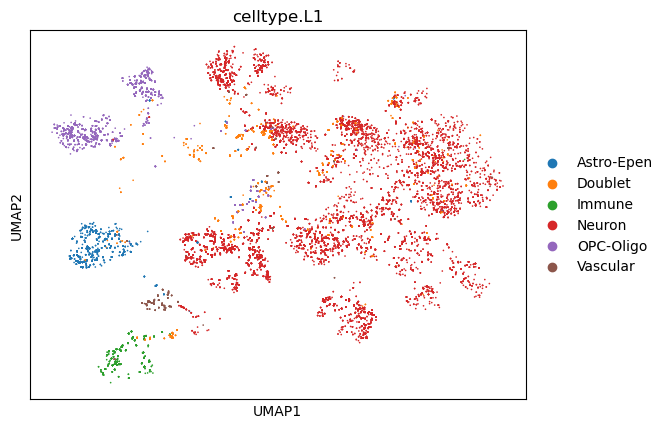

In [15]:
sc.pl.umap(adata_sc[rs[0]],color='celltype.L1')

/home/junyichen/anaconda3/envs/allcools/lib/python3.8/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/junyichen/anaconda3/envs/allcools/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/junyichen/anaconda3/envs/allcools/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


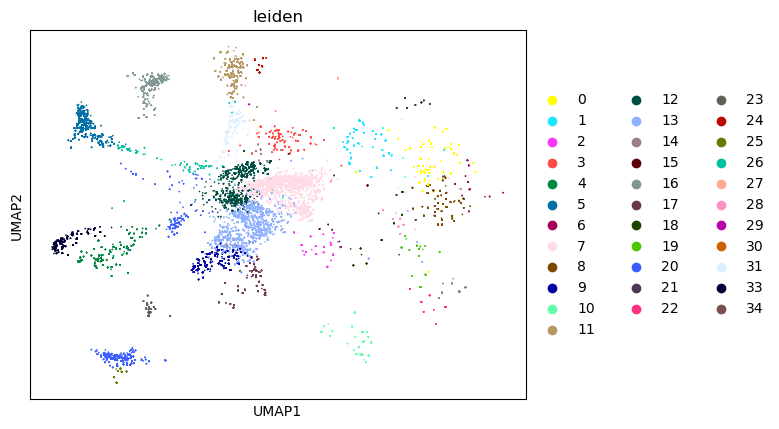

In [16]:
sc.pl.umap(adata_atac[rs[1]],color='leiden')

In [27]:
len(set(rs[1]))

3438

In [28]:
len(set(rs[0]))

3558

In [ ]:
k_index_2 = cKDTree(adata_atac.obsm['X_pca_harmony']).query(x=adata_sc.obsm['X_pca_harmony'], k=20, workers=10)

In [ ]:
k_index_2

In [ ]:
m1,m2 = find_mutual_nn(adata_sc.obsm['X_pca'], adata_atac.obsm['X_pca'], 20, 20, 1)

In [ ]:
m1

In [ ]:
import mnnpy as mn
corrected = mn.mnn_correct(adata_sc, adata_atac, batch_categories = ["sc", "atac"])